# Introduction
Over 1000 images of cats and dogs scraped off of google images. 
Is it a cat or a dog?

Image sizes range from roughly 100x100 pixels to 2000x1000 pixels.
Image format is jpeg.
Duplicates have been removed.
An 80/20 split was used between train and test.

Code adapted from pytorch.org tutorials

In [1]:
# Package imports go here
import numpy as np
import matplotlib.pyplot as plt

import time 
import os
import copy 

import torch
import torch.nn as nn                 # neural network
import torch.optim as optim           # optimization
from torch.optim import lr_scheduler  # adjusting the learning rate based on the number of epochs
import torch.backends.cudnn as cudnn  # a means for PyTorch to talk to the GPU

import torchvision                    # additional functionalities to manipulate and process images
from torchvision import datasets, models, transforms # datasets (builtit), models (for image processing), transforms ( transform images in preparation for image processing)

Initialization
set to True for fast runtime

In [2]:
# Enable cudnn benchmark
# setting it to True allows inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware
cudnn.benchmark = True

# Data
kaggle datasets: samuelcortinhas/cats-and-dogs-image-classification
"train" and "test"
labels: cats, dogs

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Upload kaggle.json containing api key to google colab env (originally in /Downloads/kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amnesiac1974","key":"6facd47d2a776640c0e0b50680233e9f"}'}

In [5]:
# authenticate with kaggle.json
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download dataset 
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

# Create the subfolder if it doesn't exist
subfolder = 'data/cats_vs_dogs'
os.makedirs(subfolder, exist_ok=True)

# Unzip the downloaded dataset into the subfolder
!unzip '*.zip' -d {subfolder}

 95% 61.0M/64.4M [00:00<00:00, 115MB/s]
100% 64.4M/64.4M [00:00<00:00, 102MB/s]
Archive:  cats-and-dogs-image-classification.zip
  inflating: data/cats_vs_dogs/test/cats/cat_1.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_106.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_109.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_113.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_114.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_116.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_118.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_119.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_124.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_140.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_147.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_156.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_158.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_162.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_18.jpg  
  inflating: data/cats_vs_dogs/test/cats/cat_190.

# Data transformation
Normalize(), used to normalize a tensor image with given means and standard deviations, passed as lists as the first and second arguments, respectively (taking tensors as input). 
The images are assumed to be similar to ImageNet images, therefore used the mean and standard deviation of the ImageNet dataset. These are:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [8]:
# Create data transforms
data_transforms = {
    'train' : transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    ),
    'test' : transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
        ]
    )
}

In [9]:
# Provide data directory
data_dir = 'data/cats_vs_dogs'

# Create image folders for our training and validation data 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]
                                         )
                 for x in ['train', 'test']}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# Obtain class_names from image_datasets
class_names = image_datasets['train'].classes
print(class_names)

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size = 4,          
                                              shuffle=True)
               for x in ['train', 'test']}

['cats', 'dogs']


In [10]:
# Change selected device to CUDA, a parallel processing platform, if available
# In google colab "GPU" selected under Runtime>Change Runtime type>GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize cats and dogs with custom functions

In [11]:
def imshow(inp, title=None):
    """
    This function will make use of Matplotlib.pyplot's imshow() function for tensors. 
    It will show the same number of images as the batch we defined.
    """
    # A transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0)) 

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    
    # To visualize the correct colors     
    inp = std * inp + mean
    
    # To view a clipped version of an image             
    inp = np.clip(inp, 0, 1)
    
    # Visualize inp
    plt.imshow(inp)
    
    if title is not None: # Plot title goes here
        plt.title(title)
    plt.pause(0.001)  # Enables the function to pause while the plots are updated


Calling imshow() on training data

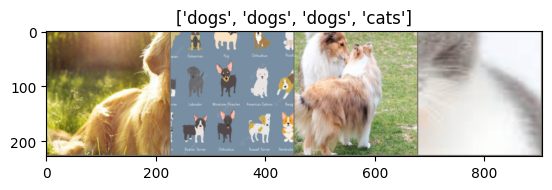

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

Calling imshow() on test data

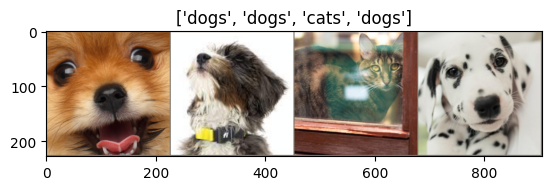

In [13]:
# Get a batch of validation data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title = [class_names[x] for x in classes])

# Running the model
Apply pretrained model on data using train_model()
Defining functions for training model and testing model
25 epochs: the number of times the model or learning algorithm will encounter all samples in the dataset. In one epoch, the complete dataset will have had an opportunity to update the internal model parameters.

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''
    
    since = time.time()

    # Make a deep copy of the model provided     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    '''
    Function that will visualize results of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Load pre-trained model
using a model called ResNet18

In [17]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.1MB/s]


In [18]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
# Accuracy relates to number of errors in the data:
# a low accuracy and huge loss means you made huge errors on a lot of data
# a low accuracy but low loss means you made little errors on a lot of data
# a great accuracy with low loss means you made low errors on a few data (best case)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6225 Acc: 0.7145
test Loss: 0.2850 Acc: 0.8929

Epoch 1/24
----------
train Loss: 0.6445 Acc: 0.7684
test Loss: 0.1432 Acc: 0.9429

Epoch 2/24
----------
train Loss: 0.4677 Acc: 0.8061
test Loss: 0.2105 Acc: 0.9143

Epoch 3/24
----------
train Loss: 0.4699 Acc: 0.8061
test Loss: 0.1460 Acc: 0.9071

Epoch 4/24
----------
train Loss: 0.5583 Acc: 0.7810
test Loss: 0.1493 Acc: 0.9357

Epoch 5/24
----------
train Loss: 0.5241 Acc: 0.8205
test Loss: 0.8466 Acc: 0.7214

Epoch 6/24
----------
train Loss: 0.6266 Acc: 0.7864
test Loss: 0.3791 Acc: 0.8857

Epoch 7/24
----------
train Loss: 0.5503 Acc: 0.8115
test Loss: 0.1880 Acc: 0.9071

Epoch 8/24
----------
train Loss: 0.4159 Acc: 0.8169
test Loss: 0.1308 Acc: 0.9429

Epoch 9/24
----------
train Loss: 0.3411 Acc: 0.8474
test Loss: 0.1384 Acc: 0.9429

Epoch 10/24
----------
train Loss: 0.3677 Acc: 0.8259
test Loss: 0.1228 Acc: 0.9429

Epoch 11/24
----------
train Loss: 0.3181 Acc: 0.8725
test Loss: 0.1510 Acc

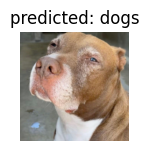

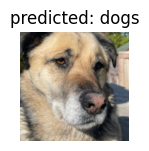

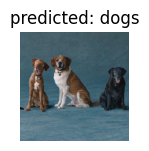

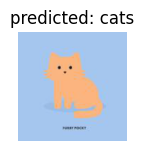

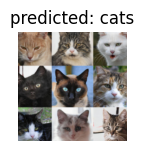

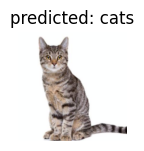

In [19]:
visualize_model(model_ft)

In [20]:
# Disable gradients for model_conv.parameters()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_conv = model_conv.to(device)

# Set criterion again
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
# Train model_conv
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5553 Acc: 0.7522
test Loss: 0.1795 Acc: 0.9071

Epoch 1/24
----------
train Loss: 0.4383 Acc: 0.8007
test Loss: 0.4429 Acc: 0.8357

Epoch 2/24
----------
train Loss: 0.4774 Acc: 0.7989
test Loss: 0.1127 Acc: 0.9643

Epoch 3/24
----------
train Loss: 0.3847 Acc: 0.8474
test Loss: 0.0992 Acc: 0.9714

Epoch 4/24
----------
train Loss: 0.4552 Acc: 0.8205
test Loss: 0.1847 Acc: 0.9071

Epoch 5/24
----------
train Loss: 0.4394 Acc: 0.8330
test Loss: 0.1089 Acc: 0.9286

Epoch 6/24
----------
train Loss: 0.5091 Acc: 0.8169
test Loss: 0.2311 Acc: 0.9071

Epoch 7/24
----------
train Loss: 0.4068 Acc: 0.8259
test Loss: 0.1000 Acc: 0.9357

Epoch 8/24
----------
train Loss: 0.3947 Acc: 0.8366
test Loss: 0.1553 Acc: 0.9286

Epoch 9/24
----------
train Loss: 0.3823 Acc: 0.8205
test Loss: 0.0811 Acc: 0.9643

Epoch 10/24
----------
train Loss: 0.3482 Acc: 0.8402
test Loss: 0.0878 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.3394 Acc: 0.8438
test Loss: 0.0725 Acc

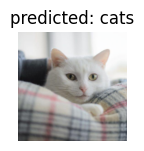

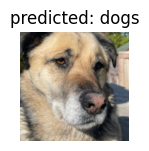

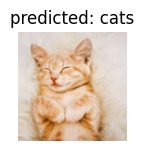

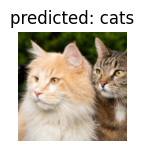

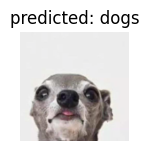

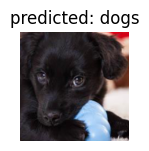

In [22]:
# Visualize model
visualize_model(model_conv)
plt.show()